In [3]:
import nltk
import re
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from tqdm import tqdm
import warnings

warnings.filterwarnings(action='ignore')

nltk.download('stopwords')
nltk.download('wordnet')

data = pd.read_csv('data/mpst_full_data.csv')
data = data.drop_duplicates(subset='plot_synopsis')
data.head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lizag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb


In [4]:
data["tag_count"] = data["tags"].apply(lambda text: len(str(text).split(", ")))
data.head(3)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1


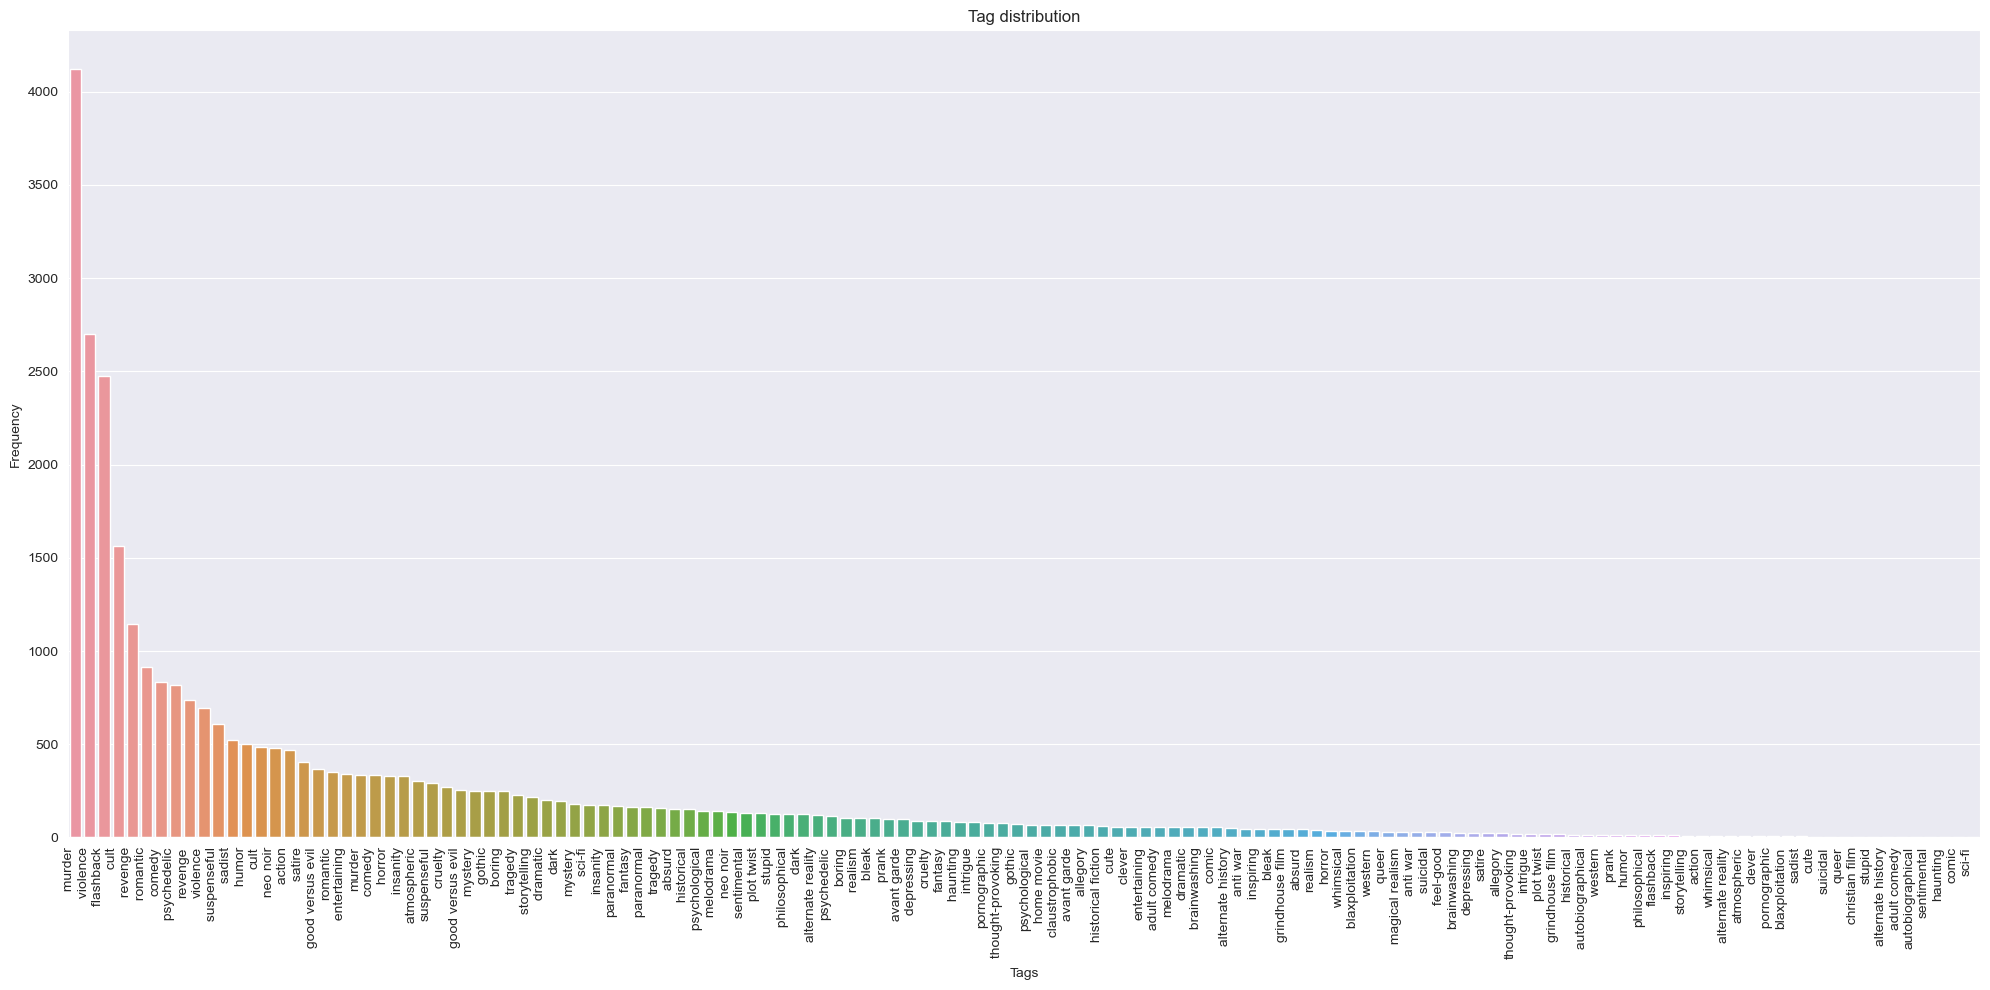

In [29]:
tag_counts = data['tags'].str.split(',').explode().value_counts()

plt.figure(figsize=(20, 10))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
top_4_tags = tag_counts.nlargest(4)
plt.title('Tag distribution')
plt.xlabel('Tags')
plt.ylabel('Frequency')

plt.xticks(rotation=90, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

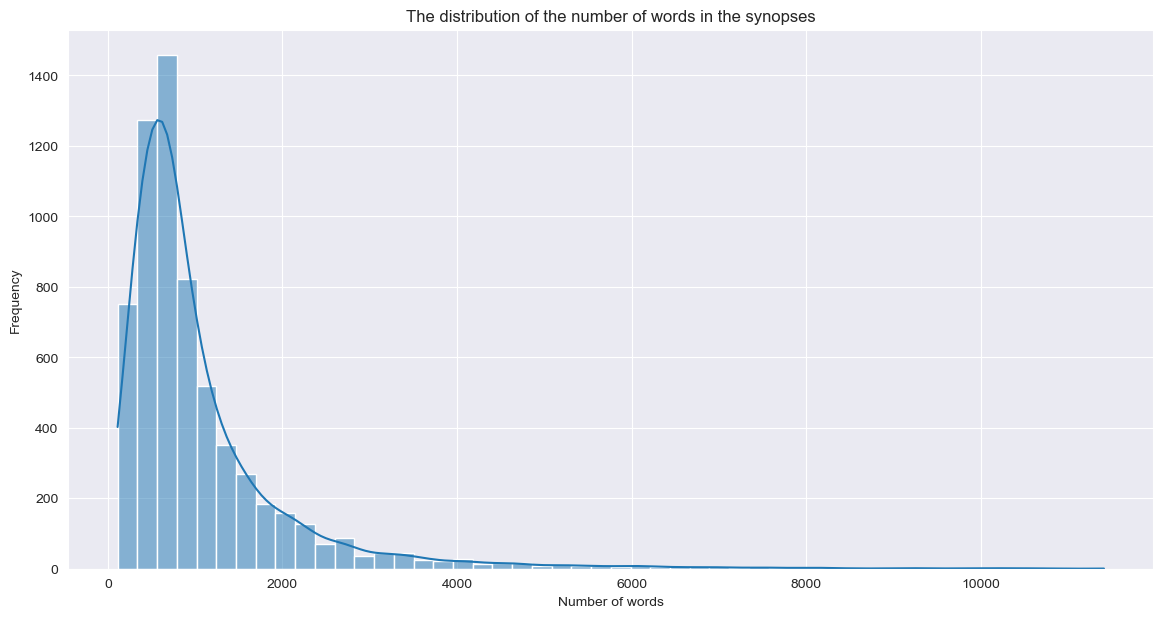

In [30]:
data['word_count'] = data['plot_synopsis'].apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 7))
sns.histplot(data['word_count'], bins=50, kde=True)
plt.title('The distribution of the number of words in the synopses')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()

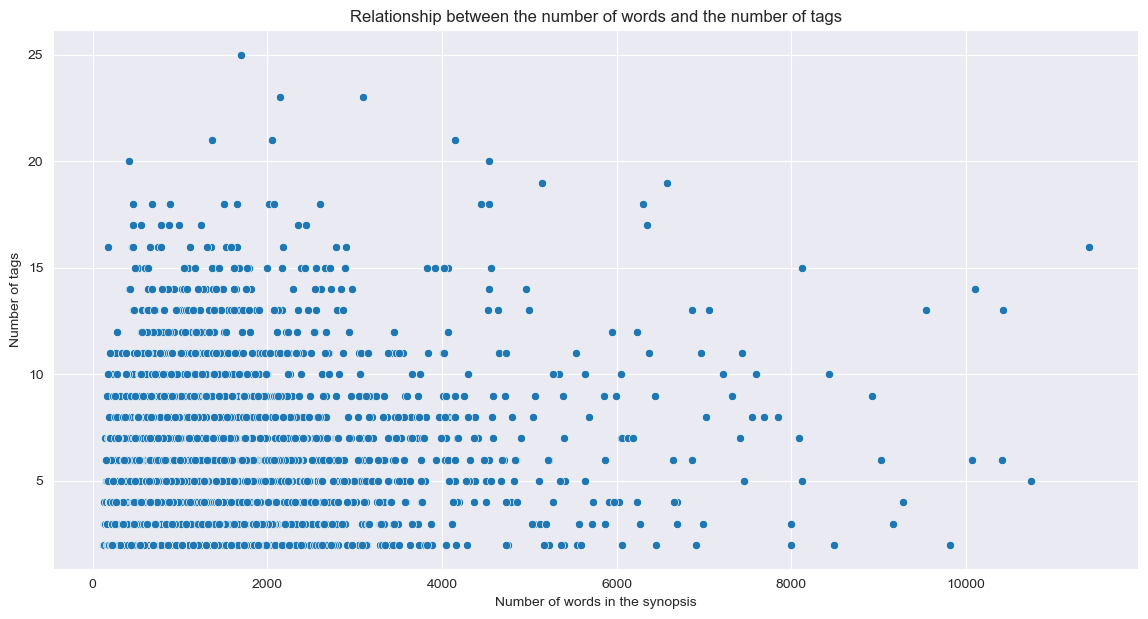

In [31]:
plt.figure(figsize=(14, 7))
data['tag_count'] = data['tags'].apply(lambda x: len(x.split(',')))
sns.scatterplot(x=data['word_count'], y=data['tag_count'])
plt.title('Relationship between the number of words and the number of tags')
plt.xlabel('Number of words in the synopsis')
plt.ylabel('Number of tags')
plt.show()

### Text processing

In [9]:
def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }

    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    return text

In [10]:
stop_words = set(nltk_stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()


def process_synopsis(synopsis, stop_words, stemmer, lemmatizer):
    synopsis = re.sub(r"http\S+", "", synopsis)
    synopsis = BeautifulSoup(synopsis, 'lxml').get_text()
    synopsis = expand_contractions(synopsis)
    synopsis = re.sub(r"\S*\d\S*", "", synopsis).strip()
    synopsis = re.sub(r'[^A-Za-z]+', ' ', synopsis)

    processed_words = [
        stemmer.stem(lemmatizer.lemmatize(word.lower())).encode('utf8')
        for word in synopsis.split() if word.lower() not in stop_words
    ]

    return b' '.join(processed_words)

In [11]:
cleaned_synopses = [
    process_synopsis(synopsis, stop_words, stemmer, lemmatizer)
    for synopsis in tqdm(data['plot_synopsis'].values)
]

data['cleaned_synopsis'] = cleaned_synopses
data['cleaned_synopsis'] = data['cleaned_synopsis'].str.decode("utf-8")
data.head(4)

100%|██████████| 13848/13848 [07:23<00:00, 31.23it/s]


,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count,word_count,cleaned_synopsis
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb,5,1315,note synopsi orgin italian releas segment cert...
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb,1,378,two thousand year ago nhagruul foul sorcer rev...
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb,1,707,matuschek gift store budapest workplac alfr kr...
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb,4,2317,glenn holland morn person anyon standard woken...


In [35]:
def filter_top_tags(tags):
    return ','.join([tag for tag in tags.split(',') if tag in top_4_tags])


data['filtered_tags'] = data['tags'].apply(filter_top_tags)
data = data[data['filtered_tags'] != '']

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(data['cleaned_synopsis'])

mlb = MultiLabelBinarizer(classes=top_4_tags.index.tolist())
y = mlb.fit_transform(data['filtered_tags'].str.split(','))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Models

#### Logistic regression

In [15]:
param_grid_lr = {'estimator__C': [0.1, 1, 10]}
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
grid_lr = GridSearchCV(lr_model, param_grid_lr, scoring='f1_micro', cv=3)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                        max_iter=1000)),
             param_grid={'estimator__C': [0.1, 1, 10]}, scoring='f1_micro')

#### SVM

In [18]:
param_grid_svm = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf']
}
svm_model = OneVsRestClassifier(SVC(class_weight='balanced'))
grid_svm = GridSearchCV(svm_model, param_grid_svm, scoring='f1_micro', cv=3)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SVC(class_weight='balanced')),
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__kernel': ['linear', 'rbf']},
             scoring='f1_micro')

####  Random Forest

In [19]:
param_grid_rf = {
'estimator__n_estimators':[100, 200],
    'estimator__max_depth': [None, 10, 20]
}
rf_model = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'))
grid_rf = GridSearchCV(rf_model, param_grid_rf, scoring='f1_micro', cv=3)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced')),
             param_grid={'estimator__max_depth': [None, 10, 20],
                         'estimator__n_estimators': [100, 200]},
             scoring='f1_micro')

### Evaluating models and choosing the best one

 **Micro-Averaging (f1_micro)**: Считает общие истинные положительные, ложные положительные и ложные отрицательные для всех классов. Это хорошо подходит, когда важно учитывать вклад каждого экземпляра одинаково.

In [20]:
models_results = {
    'Logistic Regression': grid_lr,
    'SVM': grid_svm,
    'Random Forest': grid_rf,
}

results_table = []

for model_name, model in models_results.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    accuracy = accuracy_score(y_test, y_pred)
    results_table.append({
        'Model': model_name,
        'Best Parameters': model.best_params_,
        'F1 Score': f1,
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results_table)
print(results_df)

best_model_name = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
best_model = models_results[best_model_name]
print(f'Best Model: {best_model_name}')

                 Model                                    Best Parameters  \
0  Logistic Regression                                {'estimator__C': 1}   
1                  SVM  {'estimator__C': 1, 'estimator__kernel': 'line...   
2        Random Forest  {'estimator__max_depth': 10, 'estimator__n_est...   

   F1 Score  Accuracy  
0  0.607481  0.208885  
1  0.603749  0.186282  
2  0.648034  0.278254  
Best Model: Random Forest


Классы очень несбалансированы, поэтому результаты получаются средними 

### Testing the best model and displaying the results

In [28]:
y_pred_best = best_model.predict(X_test)

print(f"Classification Report for Random Forest:\n")
print(classification_report(y_test, y_pred_best, target_names=top_4_tags.index.tolist(), zero_division=0))

Classification Report for Random Forest:


AttributeError: 'builtin_function_or_method' object has no attribute 'tolist'

In [23]:
random_index = np.random.randint(0, X_test.shape[0])
sample_text = X_test[random_index]

true_labels = y_test[random_index]
predicted_labels = y_pred_best[random_index]

true_labels_array = np.array([true_labels])
predicted_labels_array = np.array([predicted_labels])

true_labels_tags = mlb.inverse_transform(true_labels_array)
tags_list = [tag for sublist in true_labels_tags for tag in sublist]
tags_str = ', '.join(tags_list)

predicted_labels_tags = mlb.inverse_transform(predicted_labels_array)
predicted_tags_list = [tag for sublist in predicted_labels_tags for tag in sublist]
predicted_tags_str = ', '.join(predicted_tags_list)

print(f"Sample Text: {data.iloc[random_index]['plot_synopsis']}")
print(f'True tags: {tags_str}')
print(f"Predicted Labels: {predicted_tags_str}")

Sample Text: A young blonde model called Lisa Convey (Terri Welles) appears in a commercial for Ravish, (narrated by John Erwin's voice) a perfume who claims to fulfill women's deepest desires. The model goes to Dr. Larry Roberts (Albert Finney), a Beverly Hills plastic surgeon with very specific demands, in the range of millimeters. Dr. Roberts is puzzled, but accepts because his business partner, Dr Jim Belfield (Darryl Hickman) says that if Roberts doesn't do it, a less competent surgeon will do it. The surgery is successful, and we see all the process taken place. The model goes back to her life, and in company of his dog Teddy is undressing up for her boyfriend Bob to arrive to her luxury flat. Somebody insists in ringing the bell, and she opens it up because she thinks it's Bob, but she can't see anyone. She feels a bit dazzled and confused. She looks around the flat, and notices her dog Teddy barking to the air. There seems to be nobody around, but the front door closes by itsel

In [24]:
new_movie_description = """
Two American bailiffs are sent to one of the islands in Massachusetts to investigate the disappearance of a patient at a clinic for insane criminals. During the investigation, they will have to face a web of lies, a hurricane and a deadly riot of the clinic's inhabitants.
"""

processed_new_description = process_synopsis(new_movie_description, stop_words, stemmer, lemmatizer)
vectorized_new_description = tfidf_vectorizer.transform([processed_new_description.decode("utf-8")])
predicted_new_labels = best_model.predict(vectorized_new_description)

predicted_labels_list = mlb.inverse_transform(predicted_new_labels)[0]
predicted_labels_string = ", ".join(predicted_labels_list)

print(f"New Movie Description: {new_movie_description}")
print(f"Predicted Labels for New Movie: {predicted_labels_string}")

New Movie Description: 
Two American bailiffs are sent to one of the islands in Massachusetts to investigate the disappearance of a patient at a clinic for insane criminals. During the investigation, they will have to face a web of lies, a hurricane and a deadly riot of the clinic's inhabitants.

Predicted Labels for New Movie:  murder


### Saving a model for tg bot

In [ ]:
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(mlb, 'mlb.pkl')
joblib.dump(stop_words, 'stop_words.pkl')
joblib.dump(stemmer, 'stemmer.pkl')
joblib.dump(lemmatizer, 'lemmatizer.pkl')